In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

#### 데이터 준비

In [2]:
df = pd.read_csv('data/RocketLaunchDataCompleted2.csv', encoding='cp949')
df.head()

,Crewed or Uncrewed,Launched?,High Temp,Low Temp,Ave Temp,Hist High Temp,Hist Low Temp,Hist Ave Temp,Percipitation at Launch Time,Hist Ave Percipitation,Wind Direction,Max Wind Speed,Visibility,Condition,target
0,Uncrewed,N,75.0,68.0,71.00,75.0,55.0,65.0,0.0,0.08,E,16.0,15.0,Cloudy,0
1,Uncrewed,N,78.0,70.0,73.39,75.0,55.0,65.0,0.0,0.09,E,14.0,10.0,Cloudy,0
2,Uncrewed,Y,73.0,0.0,60.21,75.0,55.0,65.0,0.0,0.09,NE,15.0,10.0,Cloudy,1
3,Uncrewed,N,76.0,57.0,66.04,75.0,55.0,65.0,0.0,0.08,N,10.0,10.0,Partly Cloudy,0
4,Uncrewed,N,79.0,60.0,70.52,75.0,55.0,65.0,0.0,0.09,E,12.0,10.0,Partly Cloudy,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Crewed or Uncrewed            300 non-null    object 
 1   Launched?                     300 non-null    object 
 2   High Temp                     300 non-null    float64
 3   Low Temp                      300 non-null    float64
 4   Ave Temp                      300 non-null    float64
 5   Hist High Temp                300 non-null    float64
 6   Hist Low Temp                 300 non-null    float64
 7   Hist Ave Temp                 300 non-null    float64
 8   Percipitation at Launch Time  300 non-null    float64
 9   Hist Ave Percipitation        300 non-null    float64
 10  Wind Direction                300 non-null    object 
 11  Max Wind Speed                300 non-null    float64
 12  Visibility                    300 non-null    float64
 13  Condi

### 독립변수, 종속변수 지정

In [4]:
X = df.drop(['Launched?', 'target'], axis=1)
y = df['target']

In [5]:
# -----------------
# 데이터 유형 파악
# -----------------
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include='number').columns

### 훈련세트/테스트세트 분할

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((225, 13), (75, 13), (225,), (75,))

### 전처리 파이프라인

In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# -----------------------------
# ColumnTransformer 구성
#   - "cat" : 범주형 → OneHotEncoder
#   - "num" : 수치형 → StandardScaler
#   remainder="passthrough" : transformers에 포함되지 않은 컬럼은 변환 없이 그대로 유지
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
    remainder="passthrough"   # drop 으로 바꾸면 나머지 컬럼을 제거
)

### 훈련 및 평가

In [8]:
# --------------------------------------------
# 파이프라인 정의
# --------------------------------------------
from sklearn.pipeline import Pipeline       
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced'))
])



In [9]:
# --------------------------------------------
# 훈련
# --------------------------------------------
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
# ---------------------------
# 정확도
# ---------------------------
pipeline.score(X_test, y_test)

0.8133333333333334

In [11]:
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        60
           1       1.00      0.07      0.12        15

    accuracy                           0.81        75
   macro avg       0.91      0.53      0.51        75
weighted avg       0.85      0.81      0.74        75



In [12]:
from sklearn.metrics import confusion_matrix
y_pred = pipeline.predict(X_test)
confusion_matrix(y_test, y_pred)


array([[60,  0],
       [14,  1]])

### pipeline에서 모델의 학습결과 확인
* 파이프라인에서 각 스텝의 결과 가져오기
    - `pipeline.named_steps['단계명']`

In [13]:
# ------------------------------
# 모델 객체 가져오기
# ------------------------------
model = pipeline.named_steps['rf']

In [14]:
# ------------------------------
# 모델이 학습한 결과 확인 - 특성의 중요도
# ------------------------------
importance = model.feature_importances_
importance


array([0.06613216, 0.07951586, 0.0234583 , 0.00752386, 0.0162501 ,
       0.00940083, 0.00826679, 0.0107429 , 0.00770006, 0.00422081,
       0.01280267, 0.02036698, 0.00259907, 0.01483254, 0.00171068,
       0.00048143, 0.00062558, 0.00387603, 0.02037956, 0.00501729,
       0.00533935, 0.00100145, 0.08891525, 0.06764613, 0.11122516,
       0.05222561, 0.04788871, 0.05374286, 0.05020298, 0.06190902,
       0.08076393, 0.06323606])

In [15]:
# ------------------------------
# 모델이 학습한 결과 확인 - feature_names
# ------------------------------
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

<Axes: ylabel='feature_names'>

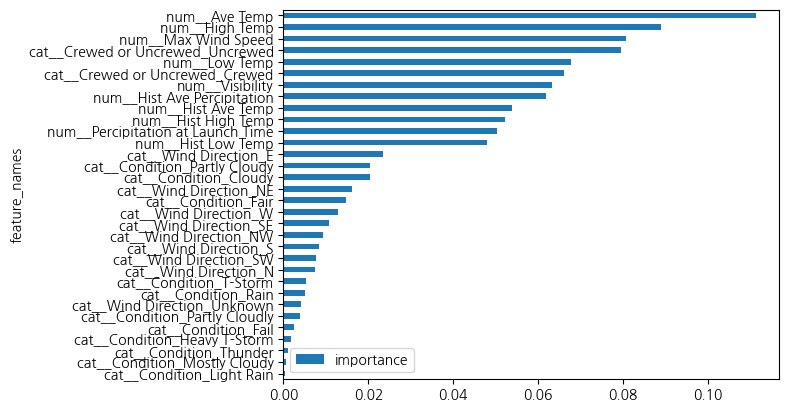

In [16]:
# ------------------------------
# 모델이 학습한 결과 확인 - 특성의 중요도 시각화
# ------------------------------
df_result = pd.DataFrame()
df_result['feature_names'] = feature_names
df_result['importance'] = importance
df_result.sort_values('importance').plot(kind='barh', x='feature_names')